In [1]:
#Eine Day-ahead Prognose für den deutschen Strommarkt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from keras.layers import Dense,LSTM,Dropout, GRU, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math as m


#SMARD DATEN 
df= pd.read_csv("price_data.csv",sep=",",index_col=0)
df.index = pd.to_datetime(df.index)

def split_dataset(length, dataset):
    "Aufteilung Dataset in Train und Test"
    train,test=dataset[:length],dataset[length:]
    return(train, test)


def dataset_preparing(inputs,outputs, dataset):
    " Teilt das Dataset in Inputvektoren und Outputvektoren ein"
    x_i=[]
    y_i=[]
    for i in range(inputs,len(dataset)-outputs,outputs):
        x_i.append(dataset[i-inputs:i])
        y_i.append(dataset[i:i+outputs])
    return np.array(x_i), np.array(y_i)





Using TensorFlow backend.


In [3]:
#Daten skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
df=scaler.fit_transform(df.values)

In [4]:
train=split_dataset(36000,df)[0]
test=split_dataset(36000,df)[1]

In [5]:
#am Day-ahead Markt werden aufeinaml 24 kurse veröffentlicht ( https://www.next-kraftwerke.de/wissen/day-ahead-handel )
X_train= dataset_preparing(168,24,train)[0]
Y_train=dataset_preparing(168,24,train)[1]
X_test=dataset_preparing(168,24,test)[0]
Y_test=dataset_preparing(168,24,test)[1]

In [6]:
#Reshaping für LSTM/GRU
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))
Y_test=np.reshape(Y_test,(Y_test.shape[0],Y_test.shape[1]))

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [7]:
#LSTM Model, 3 Hidden Layer
model =  Sequential()
model.add(LSTM(units=220,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(units=140,return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(units=80,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(24)) #Output Layer 
model.add(Activation("relu")) 
model.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])


history_lstm = model.fit(X_train, Y_train, epochs=50, batch_size=120,validation_data=(X_test,Y_test),shuffle=False)
model.summary() 


Train on 1492 samples, validate on 491 samples
Epoch 1/50
1492/1492 [==============================] - 28s 19ms/step - loss: 0.0923 - mean_squared_error: 0.0150 - val_loss: 0.0797 - val_mean_squared_error: 0.0125
Epoch 2/50
1492/1492 [==============================] - 26s 17ms/step - loss: 0.0856 - mean_squared_error: 0.0132 - val_loss: 0.0838 - val_mean_squared_error: 0.0132
Epoch 3/50
1492/1492 [==============================] - 28s 19ms/step - loss: 0.0874 - mean_squared_error: 0.0133 - val_loss: 0.0631 - val_mean_squared_error: 0.0086
Epoch 4/50
1492/1492 [==============================] - 30s 20ms/step - loss: 0.0738 - mean_squared_error: 0.0100 - val_loss: 0.0583 - val_mean_squared_error: 0.0077
Epoch 5/50
1492/1492 [==============================] - 27s 18ms/step - loss: 0.0694 - mean_squared_error: 0.0089 - val_loss: 0.0577 - val_mean_squared_error: 0.0074
Epoch 6/50
1492/1492 [==============================] - 27s 18ms/step - loss: 0.0657 - mean_squared_error: 0.0083 - val_los

Epoch 50/50
1492/1492 [==============================] - 27s 18ms/step - loss: 0.0508 - mean_squared_error: 0.0057 - val_loss: 0.0514 - val_mean_squared_error: 0.0067
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 168, 220)          195360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 220)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 140)          202160    
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 140)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                70720     
_________________________________________________________________
dropout_3 (Dropout)

In [8]:
#GRU Model, 3 Hidden Layer

model_GRU =  Sequential()
model_GRU.add(GRU(units=180,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_GRU.add(Dropout(0.5))
model_GRU.add(GRU(units=100,return_sequences=True))
model_GRU.add(Dropout(0.5))
model_GRU.add(GRU(units=64,return_sequences=False))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(24))
model_GRU.add(Activation("relu")) 
model_GRU.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])


history_GRU = model_GRU.fit(X_train, Y_train, epochs=50, batch_size=100,validation_data=(X_test,Y_test),shuffle=False)
model_GRU.summary() 


Train on 1492 samples, validate on 491 samples
Epoch 1/50
1492/1492 [==============================] - 24s 16ms/step - loss: 0.0914 - mean_squared_error: 0.0145 - val_loss: 0.0695 - val_mean_squared_error: 0.0099
Epoch 2/50
1492/1492 [==============================] - 24s 16ms/step - loss: 0.0795 - mean_squared_error: 0.0118 - val_loss: 0.0680 - val_mean_squared_error: 0.0097
Epoch 3/50
1492/1492 [==============================] - 26s 17ms/step - loss: 0.0720 - mean_squared_error: 0.0098 - val_loss: 0.0622 - val_mean_squared_error: 0.0085
Epoch 4/50
1492/1492 [==============================] - 23s 16ms/step - loss: 0.0685 - mean_squared_error: 0.0088 - val_loss: 0.0568 - val_mean_squared_error: 0.0074
Epoch 5/50
1492/1492 [==============================] - 24s 16ms/step - loss: 0.0636 - mean_squared_error: 0.0078 - val_loss: 0.0552 - val_mean_squared_error: 0.0070
Epoch 6/50
1492/1492 [==============================] - 26s 17ms/step - loss: 0.0613 - mean_squared_error: 0.0075 - val_los

Epoch 50/50
1492/1492 [==============================] - 25s 17ms/step - loss: 0.0517 - mean_squared_error: 0.0058 - val_loss: 0.0502 - val_mean_squared_error: 0.0064
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 168, 180)          98280     
_________________________________________________________________
dropout_4 (Dropout)          (None, 168, 180)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 168, 100)          84300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 168, 100)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_6 (Dropout)

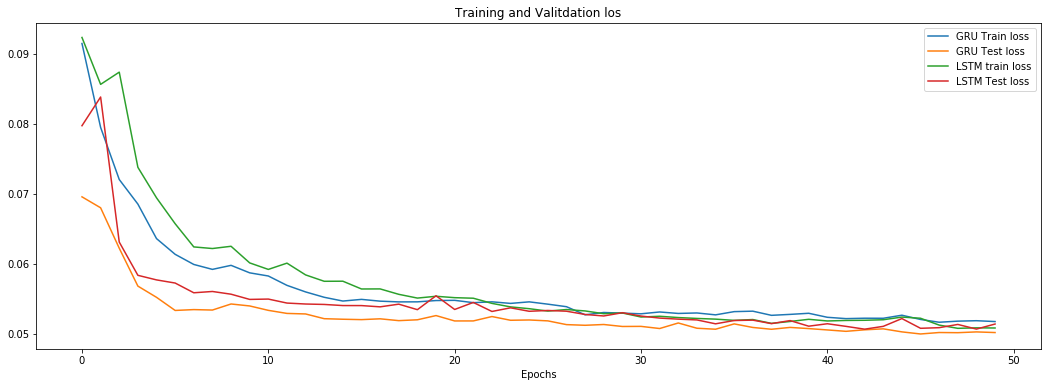

In [9]:
# Plot Training/ Test loss
#Lernfortschritte des Netzes

plt.figure(figsize=(18,6))
plt.title("Training and Valitdation los")
plt.xlabel("Epochs")
plt.plot(history_GRU.history["loss"])
plt.plot(history_GRU.history["val_loss"])
plt.plot(history_lstm.history["loss"])
plt.plot(history_lstm.history["val_loss"])
plt.legend(["GRU Train loss","GRU Test loss", "LSTM train loss", "LSTM Test loss"])
plt.show()

In [10]:
#Model prediction


predict_lstm = model.predict(X_test)
predict_lstm = scaler.inverse_transform(predict_lstm)

test_predict_GRU = model_GRU.predict(X_test)
test_predict_GRU = scaler.inverse_transform(test_predict_GRU)

In [11]:
#zrück Skalieren des Outputs
Y_test = scaler.inverse_transform(Y_test)

In [12]:
#Güte des Modells 
print("LSTM hat ein MSE von {}".format(round(mean_squared_error(Y_test,predict_lstm),2)))
print("LSTM hat ein RMSE von {}".format(round(m.sqrt(mean_squared_error(Y_test,predict_lstm)),2)))
print("GRU hat ein MSE von {}".format(round(mean_squared_error(Y_test,test_predict_GRU),2)))
print("GRU hat ein RMSE von {}".format(round(m.sqrt(mean_squared_error(Y_test,test_predict_GRU)),2)))

LSTM hat ein MSE von 143.86
LSTM hat ein RMSE von 11.99
GRU hat ein MSE von 138.22
GRU hat ein RMSE von 11.76


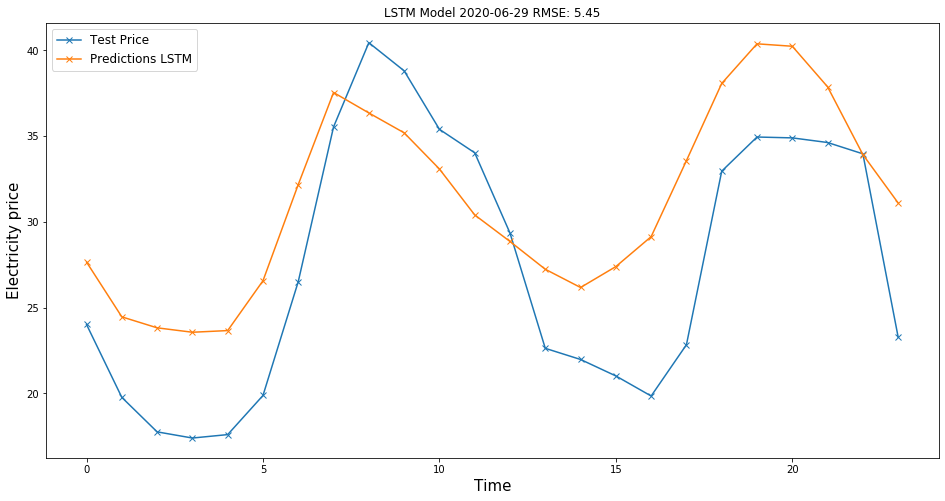

In [13]:
plt.figure(figsize=(16,8))
plt.title("LSTM Model 2020-06-29 RMSE: {}".format(round(m.sqrt(mean_squared_error(Y_test[-1],predict_lstm[-1])),2)))
plt.ylabel('Electricity price', size=15)
plt.xlabel('Time', size=15)
plt.plot(Y_test[:][-1],marker="x")
plt.plot(predict_lstm[:][-1], marker="x")
plt.legend(["Test Price","Predictions LSTM"],loc="best",prop={'size': 12})
plt.show();

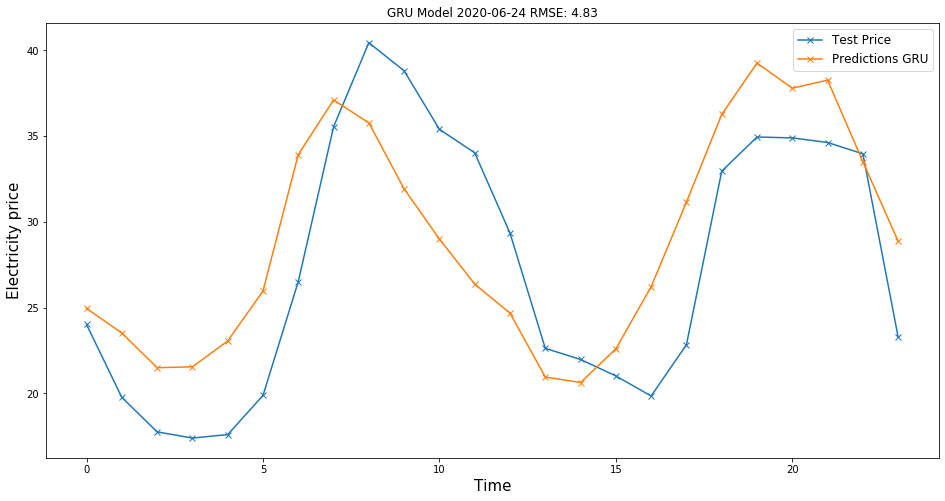

In [15]:
plt.figure(figsize=(16,8))
plt.title("GRU Model 2020-06-24 RMSE: {}".format(round(m.sqrt(mean_squared_error(Y_test[-1],test_predict_GRU[-1])),2)))
plt.ylabel('Electricity price', size=15)
plt.xlabel('Time', size=15)
plt.plot(Y_test[:][-1],marker="x")
plt.plot(test_predict_GRU[:][-1], marker="x")
plt.legend(["Test Price","Predictions GRU"],loc="best",prop={'size': 12})
plt.show();